***

* [Outline](../0_Introduction/0_introduction.ipynb)
* [Glossary](../0_Introduction/1_glossary.ipynb)
* [6. Deconvolution in Imaging](6_0_introduction.ipynb)  
    * Previous: [6.2 Interative Deconvolution with Point Sources (CLEAN)](6_2_clean.ipynb)  
    * Next: [6.4 Residuals and Image Quality](6_4_residuals_and_iqa.ipynb)

***

Import standard modules:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import HTML 
HTML('../style/course.css') #apply general CSS

Import section specific modules:

In [2]:
from astropy.io import fits
import aplpy

#Disable astropy/aplpy logging
import logging
logger0 = logging.getLogger('astropy')
logger0.setLevel(logging.CRITICAL)
logger1 = logging.getLogger('aplpy')
logger1.setLevel(logging.CRITICAL)

In [3]:
HTML('../style/code_toggle.html')

***

## 6.3 CLEAN Implementations<a id='deconv:sec:flavours'></a>

In the previous section we introduced the concept of iterative deconvolution using a point-source approximation to the sky, also known as `CLEAN`. That example was more precisely an image-domain implementation of `CLEAN`. There are in fact multiple variants of `CLEAN` as it has been extended over the years to improve results, mainly due to advancements in computing power that have lead to more compute intensive operations being possible. Today there is an active field of developing more advanced `CLEAN` implementation and deconvolution algorithms which can solve special cases. These will be briefly discussed at the end of this section. We will first discuss the implementation and advantages/disadvantages of the basic variants of `CLEAN`: image-domain, gridded visibility-domain, and visibility-domain.

As a reminder from the previous section, after deconvolution we can produce a restored image which have most of the PSF sidelobe structure, seen in the dirty image, removed:

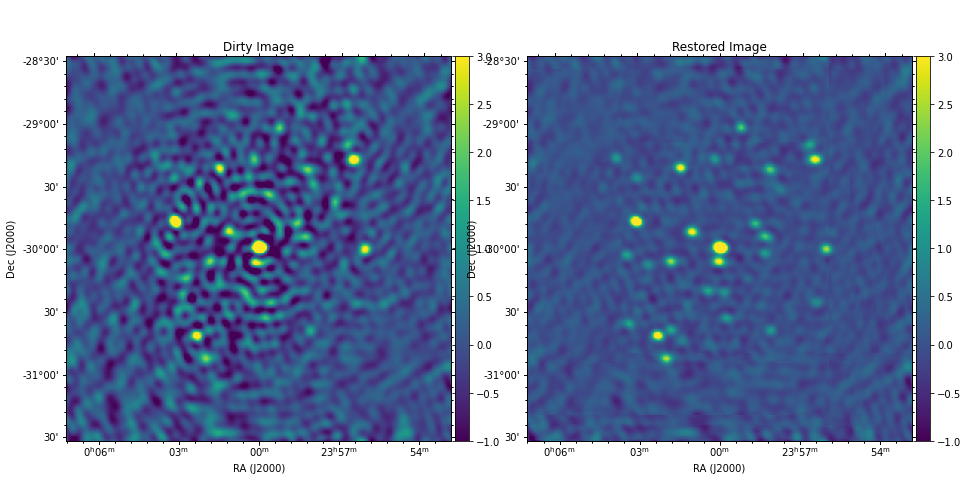

In [4]:
fig = plt.figure(figsize=(16, 7))
plt.suptitle('\n')

gc1 = aplpy.FITSFigure('../data/fits/deconv/KAT-7_6h60s_dec-30_10MHz_10chans_uniform_n100-dirty.fits', \
                       figure=fig, subplot=[0.1,0.1,0.35,0.8])
gc1.show_colorscale(vmin=-1., vmax=3.0, cmap='viridis')
# gc1.hide_axis_labels()
# gc1.hide_tick_labels()
plt.title('Dirty Image')
gc1.add_colorbar()

gc2 = aplpy.FITSFigure('../data/fits/deconv/KAT-7_6h60s_dec-30_10MHz_10chans_uniform_n300-image.fits', \
                       figure=fig, subplot=[0.5,0.1,0.35,0.8])
gc2.show_colorscale(vmin=-1., vmax=3.0, cmap='viridis')
# gc2.hide_axis_labels()
# gc2.hide_tick_labels()
plt.title('Restored Image')
gc2.add_colorbar()

fig.canvas.draw()

*Figure: restored image (right) after running CLEAN on the dirty image (left) from a KAT-7 observation.*

### 6.3.1 Image-domain (Högbom)

The first implementation of `CLEAN` was presented by [<cite data-cite='1974A&AS...15..417H'>Högbom</cite> &#10548;](http://adsabs.harvard.edu/abs/1974A%26AS...15..417H) in 1974. A notebook version of this method can be found [here &#10142;](hogbom_clean.ipynb). The basic concept is that the PSF of the observation is known, and source are point-like, so the PSF, multiplied by some flux value, can be iteratively subtracted from the image to remove these point sources. This results in a sky model of $\delta$-functions and a residual image of the noise and sky sources not removed. A pseudo-code implementation of image-domain `CLEAN` is:

$\textbf{input: } I^{D}(l,m), \ \textrm{PSF}(l,m), \ \gamma, \ f_{\textrm{thresh}}, \ N$

$\textbf{initialize: } S^{\textrm{model}} \leftarrow \{\}, I^{\textrm{res}} \leftarrow I^{D}, i \leftarrow 0$

$\textbf{while} \ \textrm{any}(I^{\textrm{res}} > f_{\textrm{thresh}}) \ \textrm{or} \ i \leq N \ \textbf{do:}$

$\qquad l_{\textrm{max}}, m_{\textrm{max}} \leftarrow \underset{l,m}{\operatorname{argmax}} I^{\textrm{res}}(l,m)$

$\qquad f_{\textrm{max}} \leftarrow I^{D}(l_{\textrm{max}}, m_{\textrm{max}})$

$\qquad I^{\textrm{res}} \leftarrow I^{\textrm{res}} - \gamma \cdot f_{\textrm{max}} \cdot \textrm{PSF}(l+l_{\textrm{max}}, m+m_{\textrm{max}})$

$\qquad S^{\textrm{model}} \leftarrow S^{\textrm{model}} + \{l_{\textrm{max}}, m_{\textrm{max}}: \gamma \cdot f_{\textrm{max}}\}$

$\qquad i \leftarrow i +1$

$\textbf{ouput: } S^{\textrm{model}}, I^{\textrm{res}}$

The inputs are the dirty image and the PSF, both of which are 2-d functions in $l$ and $m$, a loop gain parameter $\gamma$, a flux threshold $f_{\textrm{thresh}}$ or maximum number of iterations $N$ as stopping criteria.

#### Input Parameter: Loop gain $(\gamma)$

The $\gamma$ parameter ranges from 0 to 1, and controls the amount of flux subtracted with each iteration. If $\gamma=1$ then all the flux of a pixel is subtracted, this is not good as each pixel contains some amount of noise. If $\gamma=0$ then no flux is subtracted and no deconvolution occurs. Thus, $\gamma$ is set somewhere between 0 and 1, a typical value would be $0.1$, this means that each iteration 10% of the peak flux value is subtracted from the residual image. If the loop gain is too high then the deconvolution maybe over ambitious and subtract out noise from the image, leading to 'holes' in the image. If the loop gain is not large enough then the number of iterations required to complete a deconvolution will be prohibitively long.

#### Input Parameter: Stopping criteria $(N, f_{\textrm{thresh}})$

There are two stopping criteria, only one of which is needed. The first is to set the maximum number of iterations, say $N=100$, then after 100 iteration deconvolution will stop. This has the advantage of setting a fixed computation time. The other criteria is to set a flux threshold $f_{\textrm{thresh}}$ such that when the maximum flux value remaining in the residual image is at or below this threshold deconvolution is stopped. This has the advantage of deconvolving down to a known flux level.


#### Initialization and Output

Deconvolution is initialized by setting the number of iterations to 0, making a copy of the dirty image called the residual image, and creating an empty sky model. During each iteration flux will be subtracted from the residual image and a $\delta$-function source is added to the sky model representing the flux subtracted from the residual image. Once the stopping criteria is met, the completed sky model and residual image is output.

#### Iterative Loop

While the stopping criteria has not been met, a `CLEAN` iteration is done. The location $(l_{\textrm{max}}, m_{\textrm{max}})$ of the pixel with the maximum flux $f_{\textrm{max}}$ in the image is found. The PSF is offset to be centred on the peak flux pixel and multiplied by the flux value and gain loop, this is then subtracted from the residual image. The overall flux of the residual image has been reduced.

$$I^{\textrm{res}} \leftarrow I^{\textrm{res}} - \gamma \cdot f_{\textrm{max}} \cdot \textrm{PSF}(l+l_{\textrm{max}}, m+m_{\textrm{max}})$$

Then a $\delta$-function with flux $\gamma \cdot f_{\textrm{max}}$ source is added to the sky model in the position of the maximum flux.

$$S^{\textrm{model}} \leftarrow S^{\textrm{model}} + \{l_{\textrm{max}}, m_{\textrm{max}}: \gamma \cdot f_{\textrm{max}}\}$$

The new flux at ($l_{\textrm{max}}, m_{\textrm{max}}$) in the sky model is added to any flux in that position from a previous iteration.

This is the simplest implementation of `CLEAN` but is also limited as one would expect from being the original `CLEAN` method. The first issue is that the residual image and PSF are images with a fixed number of pixels. When subtracting flux from the residual image the PSF is offset, thus flux from only a subset of the residual image is subtracted. This requires either computing a PSF image at least twice as large (in both directions for 4 times the number of pixels), or limiting deconvolution to the centre of the residual image. The second issue is that the sky model is fixed to the resolution of the pixels in the residual image, this leads to artefacts as sources are never perfectly at the centre of a pixel. Accounting for these issues lead to the next developments in `CLEAN`.

### 6.3.2 Gridded Visibility-domain (Clark)

In 1980 [<cite data-cite='1980A&A....89..377C'>Clark</cite> &#10548;](http://adsabs.harvard.edu/abs/1980A%26A....89..377C) introduced a variant on Högbom's method which took advantage of fast Fourier transforms to do a form of 'batch' deconvolution in the the visibility domain after running a partial Högbom deconvolution in the image domain. An implementation of this method is left as an [exercise &#10142;](clark_clean_assignment.ipynb), a starting point notebook with helper functions is provided. The general structure of his method was to search for a set of bright pixels in the image domain (above some threshold based on the PSF sidelobes), build a partial sky model in the 'minor' cycle. The partial sky model needs to be convolved with the PSF before being subtracted from the residual image. Using the Fourier transform and convolution theorem the the sky model and PSF can be Fourier transformed and multiplied together in the visibility domain, inverse Fourier transformed back to the image domain and subtracted from the previous residual image to produce an updated residual image. This has the advantage of potentially being faster than Högbom's method, and allows for deconvolution over a larger portion of the image. This implementation in pseudo-code is:

$\textbf{input: } I^{D}(l,m), \ \textrm{PSF}(l,m), \ \gamma, \ f_{\textrm{thresh}}, \ N$

$\textbf{initialize: } S^{\textrm{model}} \leftarrow \{\}, \ I^{\textrm{res}} \leftarrow I^{D}, \ i \leftarrow 0, \ (\textrm{PSF}_{\textrm{sub}}(l,m), \ R_{\textrm{PSF}}) \leftarrow g(\textrm{PSF}(l,m))$

$\textbf{while} \ \textrm{any}(I^{\textrm{res}} > f_{\textrm{thresh}}) \ \textrm{or} \ i \leq N \ \textbf{do:} \quad [\textrm{Major Cycle}]$

$\qquad l_{\textrm{max}}, m_{\textrm{max}} \leftarrow \underset{l,m}{\operatorname{argmax}} I^{\textrm{res}}(l,m)$

$\qquad f_{\textrm{max}} \leftarrow I^{D}(l_{\textrm{max}}, m_{\textrm{max}})$

$\qquad S^{\textrm{model}}_{\textrm{partial}} \leftarrow \textrm{Hogbom}(I^{\textrm{res}}, \  \textrm{PSF}_{\textrm{sub}}, \ \gamma, \ f_{\textrm{max}} \cdot R_{\textrm{PSF}}) \quad [\textrm{Minor Cycle}]$

$\qquad V^{\textrm{model}}_{\textrm{partial}} \leftarrow \mathscr{F}\{S^{\textrm{model}}_{\textrm{partial}}\}, V^S \leftarrow \mathscr{F}\{\textrm{PSF}\}$

$\qquad I^{\textrm{res}} \leftarrow I^{\textrm{res}} - \mathscr{F}^{-1}\{V^S \cdot V^{\textrm{model}}_{\textrm{partial}}\}$

$\qquad S^{\textrm{model}} \leftarrow S^{\textrm{model}} + S^{\textrm{model}}_{\textrm{partial}}$

$\qquad i \leftarrow i +1$

$\textbf{ouput: } S^{\textrm{model}}, I^{\textrm{res}}$

The input data and parameters are the same as those for the image-domain `CLEAN`. And, uses Högbom's method as the minor cycle within the major cycle.

#### Initialization

The initialization has an extra step which selects a subset of the PSF to use in the the minor cycle image-domain `CLEAN`.

$$\textrm{PSF}_{\textrm{sub}}(l,m), \ R_{\textrm{PSF}} \leftarrow g(\textrm{PSF}(l,m))$$

The function $g$ which selects this subset is not well defined, and depends on exact implementation of the algorithm. But, generally the subset of the PSF is taken to be the central region of the PSF out to the highest sidelobes (usually the first sidelobes, except in highly redundant arrays). The function also returns the ratio $R_{\textrm{PSF}}$ of the the highest PSF sidelobe to the PSF main lobe, this will be less than 1. The justification for truncating the PSF is that the majority of the power in the PSF is contained within this region. And, any pixel in the image which is higher than the first sidelobe (as a fraction of the peak pixel flux) contains a source. The trade-off in the size of the PSF subset is that the smaller it is the more of the image can be deconvolved, but at the cost of increased errors. The larger the PSF subset the smaller the image region which can be deconvolved, but the less error-prone the deconvolution.

#### Minor Cycle

The minor cycle is a partial sky model construction using image-domain deconvolution of the current residual image using the subset of the PSF.

$$S^{\textrm{model}}_{\textrm{partial}} \leftarrow \textrm{Hogbom}(I^{\textrm{res}}, \  \textrm{PSF}_{\textrm{sub}}, \ \gamma, \ f_{\textrm{max}} \cdot R_{\textrm{PSF}})$$

The stopping criteria threshold is set to a precentage of the maximum flux based on the PSF sidelobe to main lobe ratio $f_{\textrm{max}} \cdot R_{\textrm{PSF}}$. The larger this ratio the deeper the deconvolution can be done in the minor cycle. As we do not care about the residual image at this point, we ignore this output of Högbom's method.

#### Major Cycle

The major cycle starts as does by finding the maximum flux and position, similar to Högbom's method. A call is then made to Högbom's method using a high flux threshold value, this works as a shallow deconvolution on the pixels with the most flux. The subet of the PSF is used in the minor cycle, this allows for deconvolution across a larger region of the image. From this a partial sky model is returned.

Using the computational efficiency of FFT algorithms the partial sky model and full PSF is Fourier transformed to the visibility domain. This produces an ideal sky model visibility $V^{\textrm{model}}_{\textrm{partial}}$, the array sampling function $V^S$.

$$V^{\textrm{model}}_{\textrm{partial}} \leftarrow \mathscr{F}\{S^{\textrm{model}}_{\textrm{partial}}\} \\ V^S \leftarrow \mathscr{F}\{\textrm{PSF}\}$$

The sky model visibilities are multiplied by the sampling function (this is the compute intensive convolution of the PSF and sky model in the image-domain), inverse Fourier transformed and subtracted from the residual image.

$$\qquad I^{\textrm{res}} \leftarrow I^{\textrm{res}} - \mathscr{F}^{-1}\{V^S \cdot V^{\textrm{model}}_{\textrm{partial}}\}$$

The full sky model is updated by adding in the sky model components for the minor cycle.

Clark's method of `CLEAN` deconvolution takes advantage of FFT algorithms to speed up the convolution of a partial sky model with the PSF. Using a subset of the PSF to build the image-domain sky model allows for a larger region of the image to be deconvolved, while doing the batch subtraction in the major cycle with the full PSF results in a better (and sometimes faster) deconvolution compared to just doing an image-domain deconvolution with the PSF subset. The limitations are that because the source subtraction is done on gridded visibilities this can result in errors due to the gridding and aliasing effects.

### 6.3.3 Visibility-domain (Cotton-Schwab)

`CLEAN` methods were first implemented in a time of limited computing and memory resources. Careful consideration was required in optimizing these deconvolution methods with in these constraints. This led to good approximate solutions to deconvolution. As computing power and memory has become cheaper more advanced deconvolution methods are continuously in development. These methods are beyond the scope of the course, but are part of an active field of research. See the end of this chapter for [references &#10142;](6_x_further_reading_and_references.ipynb) to current work.

After Clark's method the next major advancement was in 1984, [<cite data-cite='1984AJ.....89.1076S'>Schwab</cite> &#10548;](http://adsabs.harvard.edu/abs/1984AJ.....89.1076S) introduced a modifcation on Clark's method which performs the deconvolution on the ungridded visibilities. Just to be clear, the ungridded visibilities are the visibilities produced during an observation, before they are gridded onto a 2-D plane as descirbed in [$\S$ 5.3](../5_Imaging/5_3_gridding_and_degridding.ipynb). The Cotton-Schwab method allows for deconvolution across the entire image and does not introduce PSF artefact aliasing at the cost of an increase in computation and memory usage. The Cotton-Schwab method is still widely used today and is the basis for most subsequent `CLEAN` implementation.

Just as `CLEAN` is a general term for deconvolution using an iterative sky model subtraction process, the Cotton-Schwab method can vary based on implementation and which additional features are included. As such, it is not possible to write an easy pseudo-code implementation in the abstract. But, at a high level the Cotton-Schwab method follows Clark's major/minor cycle model. But, instead of subtracting the gridded visibilities from the sky model in the major cycle, a method is used to compute the ungridded visibilities for the sky model. There are two methods to generate ungridded visibilities from the sky model:

1. If there are only a few sources in the sky model a direct Fourier transform can be used on each source to compute the exact visibilities for each *uv* sample.
2. When there are many sources in the sky model, as is usually the case, the sky model is transformed to gridded visibilities as in Clark's methods then a [de-gridder &#10142;](../5_Imaging/5_3_gridding_and_degridding.ipynb) is used to make a close approximation to the ungridded visibilities.

These visibilities based on the sky model, often called *model visibilities*, can be used in the 'self-cal cycle', which is discussed in [$\S$8.3](../8_Calibration/8_2_1GC.ipynb). The model visibilities are subtracted from the observed visibilities resulting in *residual visibilities*. The residual visibilities are then imaged to produce a new residual image and the next iteration of deconovlution can proceed.

Deconvolving with the ungridded visibilities has a number of other advantages to Högbom and Clark's methods:

* There are no PSF aliasing effects because the deconvolution is independent of image size.
* Spatial regions of interest can be separately deconvolved or ignored, allowing for fine control over the sky modelling process.
* The w-term can be accounted for when producing the residual image from the sky model resulting in a more accurate sky model and fewer artefacts in the residual image.

At this point it should be clear that the Cotton-Schwab method (and all its derivative methods) has many advantages over the methods discussed previously in this section, and is the standard `CLEAN` deconvolution method today. It is important to note here that when the discussion of computing limits in deconvolution the gridding/de-gridding process dominates the computational operations and memory budget over all other steps. Complementary to the development of new deconvolution algorithms is the topic of efficient implementation of well developed methods. Högbom and Clark's methods are still used in some cases, such as in simple fields, and are useful to understand as there is a progression from their simplicity to the more complex modern forms of `CLEAN` used today.

### 6.3.4 The Idealized PSF and Restored Image

Often a restored image is produced as a result of deconvolution. This is the 'pretty' image which people like to show in presentations. The restored image provides no additional information beyond that of the sky model and the residual image, but is a useful visualization tool. An example restored image is show below.

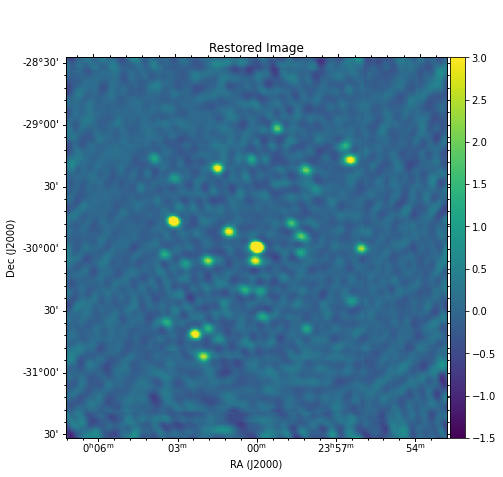

In [6]:
fig = plt.figure(figsize=(8, 7))
plt.suptitle('\n')

gc1 = aplpy.FITSFigure('../data/fits/deconv/KAT-7_6h60s_dec-30_10MHz_10chans_uniform_n300-image.fits', \
                       figure=fig)
gc1.show_colorscale(vmin=-1.5, vmax=3., cmap='viridis')
# gc1.hide_axis_labels()
# gc1.hide_tick_labels()
plt.title('Restored Image')
gc1.add_colorbar()

fig.canvas.draw()

*Figure: Restored image of a KAT-7 observation resulting from CLEAN deconvolution.*

The restored image is generated by convolving the sky model with an *ideal PSF* (or *ideal beam*) and adding in the residuals.

$$I_{\textrm{restored}} = I_{\textrm{skymodel}} \circ \textrm{PSF}_{\textrm{ideal}} + I_{\textrm{residual}}$$

Where $I_{\textrm{skymodel}}$ is a $\delta$-function image of the sky model. The ideal PSF can be defined in a number of ways, but basically it is the response of an 'ideal' interferometric array. An ideal interferometric array samples all spatial modes out to the maximum baseline of the array. This would lead to a circular sampling function and airy disc PSF which, as we have seen in [$\S$ 5.2](../5_Imaging/5_2_sampling_functions_and_psfs.ipynb) has sidelobes. A more ideal array would have a taper to make a smooth, continuous sampling function to lead to a smooth, sidelobe-free PSF, such as a Gaussian. A 2-D Gaussian, fit to the main lobe of the observation PSF, is often taken as the ideal PSF. The Gaussian function has the advantage of being easy to fit to the PSF main lobe and maintains the resolution of the image without introducing sidelobes. Other ideal PSF can be chosen, such as just selecting the main lobe of the observation PSF, but a Gaussian ideal PSF is standard in most imagers. This size scale can vary by implementation but a typical method is to fit a rotated 2-D Gaussian function to the main lobe of the PSF. Another method is to compute the full-width at half maximum of the PSF and then construct a 2-D Gaussian with the same full-width at half maximum.

When a decolvolution is performed on an image the ideal PSF size is usually computed and as part of the standard output, and put in the FITS file header. Code in the $\S$ 6.3.5 shows how to extract the ideal PSF from the header.

### 6.3.5 Deconvolution of a KAT-7 Observation

After this discussion of the various `CLEAN` implementations from an algorithmic point of view it is worthwhile to see how deconvolution looks visually as progressive iterations are performed. Using the KAT-7 observation from the previous chapter, we will step through deconvolution using the Cotton-Schwab `CLEAN` method.

In [10]:
def generalGauss2d(x0, y0, sigmax, sigmay, amp=1., theta=0.):
    """Return a normalized general 2-D Gaussian function
    x0,y0: centre position
    sigmax, sigmay: standard deviation
    amp: amplitude
    theta: rotation angle (deg)"""
    #norm = amp * (1./(2.*np.pi*(sigmax*sigmay))) #normalization factor
    norm = amp
    rtheta = theta * 180. / np.pi #convert to radians
    
    #general function parameters (https://en.wikipedia.org/wiki/Gaussian_function)
    a = (np.cos(rtheta)**2.)/(2.*(sigmax**2.)) + (np.sin(rtheta)**2.)/(2.*(sigmay**2.))
    b = -1.*(np.sin(2.*rtheta))/(4.*(sigmax**2.)) + (np.sin(2.*rtheta))/(4.*(sigmay**2.))
    c = (np.sin(rtheta)**2.)/(2.*(sigmax**2.)) + (np.cos(rtheta)**2.)/(2.*(sigmay**2.))
    return lambda x,y: norm * np.exp(-1. * (a * ((x - x0)**2.) - 2.*b*(x-x0)*(y-y0) + c * ((y-y0)**2.)))

def genRstoredBeamImg(fitsImg):
    """Generate an image of the restored PSF beam based on the FITS header and image size"""
    fh = fits.open(fitsImg)
    
    #get the restoring beam information from the FITS header
    bmin = fh[0].header['BMIN'] #restored beam minor axis (deg)
    bmaj = fh[0].header['BMAJ'] #restored beam major axis (deg)
    bpa = fh[0].header['BPA'] #restored beam angle (deg)
    dRA = fh[0].header['CDELT1'] #pixel size in RA direction (deg)
    ra0 = fh[0].header['CRPIX1'] #centre RA pixel
    dDec = fh[0].header['CDELT2'] #pixel size in Dec direction (deg)
    dec0 = fh[0].header['CRPIX2'] #centre Dec pixel

    #construct 2-D ellipitcal Gaussian function
    gFunc = generalGauss2d(0., 0., bmin/2., bmaj/2., theta=bpa)

    #produce an restored PSF beam image
    imgSize = 2.*(ra0-1) #assumes a square image
    xpos, ypos = np.mgrid[0:imgSize, 0:imgSize].astype(float) #make a grid of pixel indicies
    xpos -= ra0 #recentre
    ypos -= dec0 #recentre
    xpos *= dRA #convert pixel number to degrees
    ypos *= dDec #convert pixel number to degrees
    return gFunc(xpos, ypos) #restored PSF beam image
    
def convolveBeamSky(beamImg, skyModel):
    """Convolve a beam (PSF or restored) image with a sky model image, images must be the same shape"""
    sampFunc = np.fft.fft2(beamImg) #sampling function
    skyModelVis = np.fft.fft2(skyModel[0,0]) #sky model visibilities
    sampModelVis = sampFunc * skyModelVis #sampled sky model visibilities
    return np.abs(np.fft.fftshift(np.fft.ifft2(sampModelVis))) #sky model convolved with restored beam
    
def plotDeconvModelResidual(niter):
    """Specialized function to plot the results of a deconvolution run,
    convolves the sky model with the restoring beam for visual effect"""
    fig = plt.figure(figsize=(16, 7))
    plt.suptitle('\n')
    
    if niter > 0:
        fh = fits.open('../data/fits/deconv/KAT-7_6h60s_dec-30_10MHz_10chans_uniform_n%i-residual.fits'%niter)
        residualImg = fh[0].data
        fh = fits.open('../data/fits/deconv/KAT-7_6h60s_dec-30_10MHz_10chans_uniform_n%i-model.fits'%niter)
        skyModel = fh[0].data
    
        #generate a retored PSF beam image
        restBeam = genRstoredBeamImg(
            '../data/fits/deconv/KAT-7_6h60s_dec-30_10MHz_10chans_uniform_n%i-residual.fits'%niter)
    
        #convolve restored beam image with skymodel
        convImg = convolveBeamSky(restBeam, skyModel)

    else: #special case: niter==0
        fh = fits.open('../data/fits/deconv/KAT-7_6h60s_dec-30_10MHz_10chans_uniform_n%i-image.fits'%niter)
        residualImg = fh[0].data
        convImg = np.zeros_like(residualImg)
    
    gc1 = aplpy.FITSFigure(residualImg, figure=fig, subplot=[0.1,0.1,0.35,0.8])
    gc1.show_colorscale(vmin=-1.5, vmax=2, cmap='viridis')
    # gc1.hide_axis_labels()
    # gc1.hide_tick_labels()
    plt.title('Residual Image (niter=%i)'%niter)
    gc1.add_colorbar()
    
    gc2 = aplpy.FITSFigure(convImg, figure=fig, subplot=[0.5,0.1,0.35,0.8])
    gc2.show_colorscale(vmin=0., vmax=2.5, cmap='viridis')
    # gc2.hide_axis_labels()
    # gc2.hide_tick_labels()
    plt.title('Sky Model')
    gc2.add_colorbar()
    
    fig.canvas.draw()

def fix_aplpy_fits(aplpy_obj, dropaxis=2):
    """This removes the degenerated dimensions in APLpy 2.X...
    The input must be the object returned by aplpy.FITSFigure().
    `dropaxis` is the index where to start dropping the axis (by default it assumes the 3rd,4th place).
    """
    temp_wcs = aplpy_obj._wcs.dropaxis(dropaxis)
    temp_wcs = temp_wcs.dropaxis(dropaxis)
    aplpy_obj._wcs = temp_wcs

def plotDeconvRestored(niter):
    """Specialized function to plot the results of a deconvolution run,
    shows restored image and Fourier transform"""
    fig = plt.figure(figsize=(16, 7))
    plt.suptitle('\n')
    
    fh = fits.open('../data/fits/deconv/KAT-7_6h60s_dec-30_10MHz_10chans_uniform_n%i-image.fits'%niter)
    restoredImg = fh[0].data
    visSamples = np.abs(np.fft.fftshift(np.fft.fft2(restoredImg)))
    vsShape = visSamples.shape
    
    gc1 = aplpy.FITSFigure(restoredImg, figure=fig, subplot=[0.1,0.1,0.35,0.8])
    gc1.show_colorscale(vmin=-1.5, vmax=2, cmap='viridis')
    # gc1.hide_axis_labels()
    # gc1.hide_tick_labels()
    plt.title('Restored Image (niter=%i)'%niter)
    gc1.add_colorbar()
    
    gc2 = aplpy.FITSFigure(visSamples, figure=fig, subplot=[0.5,0.1,0.35,0.8])
    fix_aplpy_fits(gc2)
    gc2.recenter(float(vsShape[2]/2), float(vsShape[3]/2), float(vsShape[2]/6))
    gc2.show_colorscale(vmin=0, vmax=2400, cmap='viridis')
    # gc2.hide_axis_labels()
    # gc2.hide_tick_labels()
    plt.title('Visibilities (Amplitude)')
    gc2.add_colorbar()
    
    fig.canvas.draw()

In [11]:
fh = fits.open('../data/fits/deconv/KAT-7_6h60s_dec-30_10MHz_10chans_uniform_n%i-image.fits'%0)
restoredImg = fh[0].data
visSamples = np.abs(np.fft.fftshift(np.fft.fft2(restoredImg)))
visSamples.shape

(1, 1, 512, 512)

For this example we are using [<cite data-cite='2014MNRAS.444..606O'>`WSCLEAN`</cite> &#10548;](http://arxiv.org/abs/1407.1943), a multi-purpose `CLEAN` deconvlver and imager. As input we start with the observed visibilities which produces the dirty image. The dirty image is the starting point for the residual image. An empty sky model is also initialized. From here we are ready to begin the first iteration of `CLEAN`.

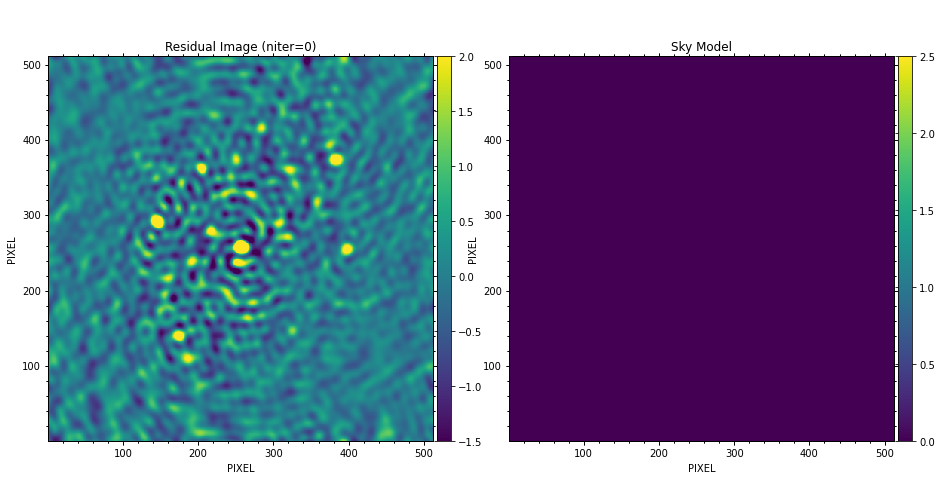

In [12]:
plotDeconvModelResidual(0)

*Figure: intial residual image is initialized as the dirty image, the initial sky model is empty.*

The first iteration finds the peak flux to be from the source in the centre of the image (see figure below). The PSF, centred on that position, is subtracted (modulated by the flux and gain value) from the residual image. A delta function in that position, with that flux is added to the sky model. Note, we have convolved the sky models below with the ideal PSF for visualization purposes. The residual image looks unchanged after one iteration as only a small amount of flux was removed from a single source. We can see that source in the updated sky model.

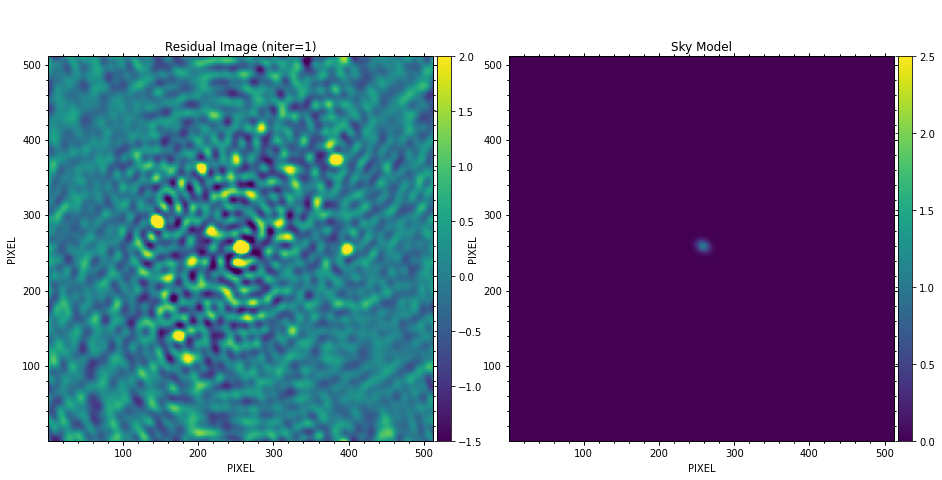

In [13]:
plotDeconvModelResidual(1)

*Figure: residual image and sky model after one iteration of CLEAN. The central source is the brightest, so a portion of that flux was transfered to the sky model leaving the residual image relatively unchanged.*

Going forward to 10 iteration we see that a significant portion of the central source has been removed from the residual image and the sidelobe beating is a bit lower. But, the central source is still present in the residual image. In the sky model a second source has also been partially deconvolved because it is now the brightest source in the residual image.

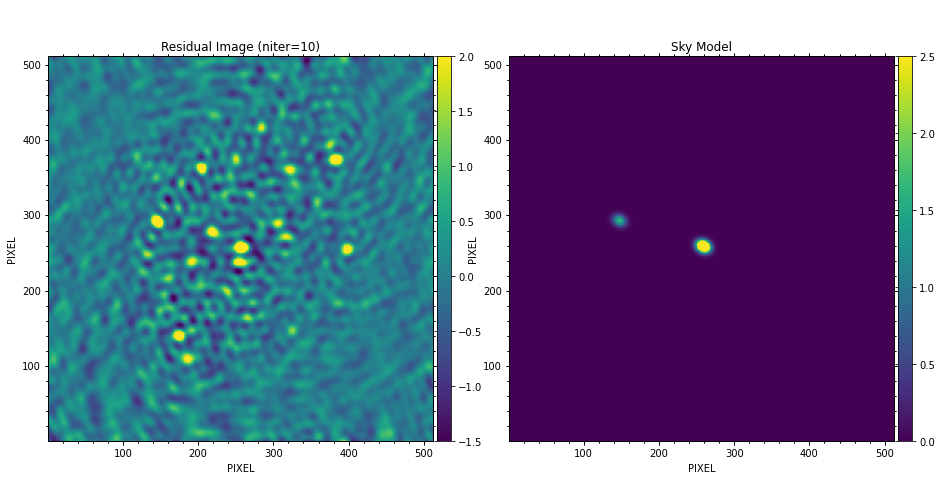

In [14]:
plotDeconvModelResidual(10)

*Figure: residual image and sky model after 10 iterations of CLEAN. A second source is partially deconvoled and added to the sky model.*

Going forward to 100 iterations we can see that many of the sources in the residual image are reduced in flux while in the sky model there are multiple sources. There is still flux left in the residual image which can be deconvolved but as we get closer to the noise floor the deconvolution process has the potential to start adding noise to the sky model.

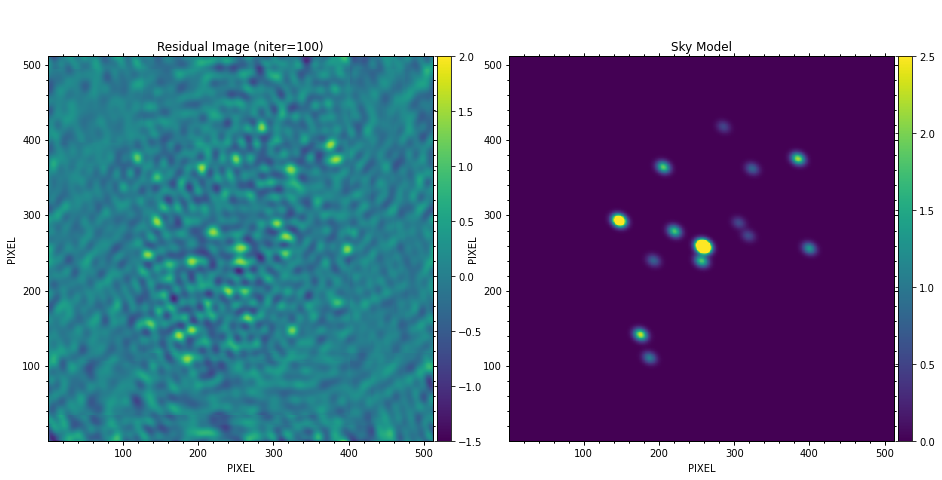

In [15]:
plotDeconvModelResidual(100)

*Figure: residual image and sky model after 100 iterations of CLEAN. Multiple sources have been deconvolved and added to the sky model, flux still remains in the residual image but the peak values re approaching the noise level of the image*

After 300 iterations the residual image is essentially noise, there is some remaining flux in the image but it is too close to the noise level to be deconvolved. The sky model now contains the final sky model with multiple point sources.

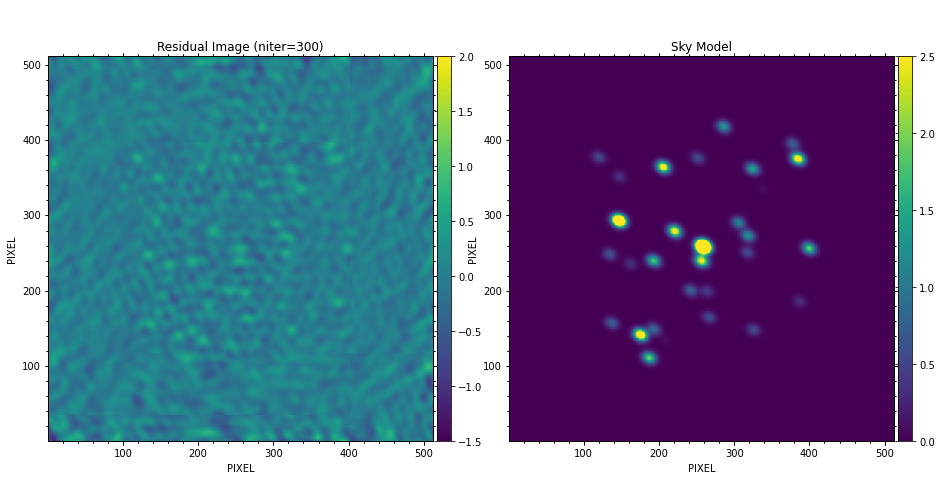

In [16]:
plotDeconvModelResidual(300)

*Figure: residual image and sky model after 300 iterations. The residual image is close to noise-like and deconvolution must be halted, the final sky model is shown on the right.*

We can look at the deconvolution process a little differently by looking at the restored image and the restored visibilities after a number of iterations. We start with visibilities which are sampled at the uv tracks of the observation which leads to an observed PSF with sidelobes. By deconvolving the creating a restored image, with an ideal PSF, we are effectively filling in the unsampled regions of the visibility plane. Remember, the Fourier transform of a Gaussian is also a Gaussian, so our ideal PSF will result in a Gaussian distribution in the visibility domain.

After only a few iterations of deconvolution (see figure below) the restored image looks similar to the dirty image and the $uv$ tracks are clear in the visibilities.

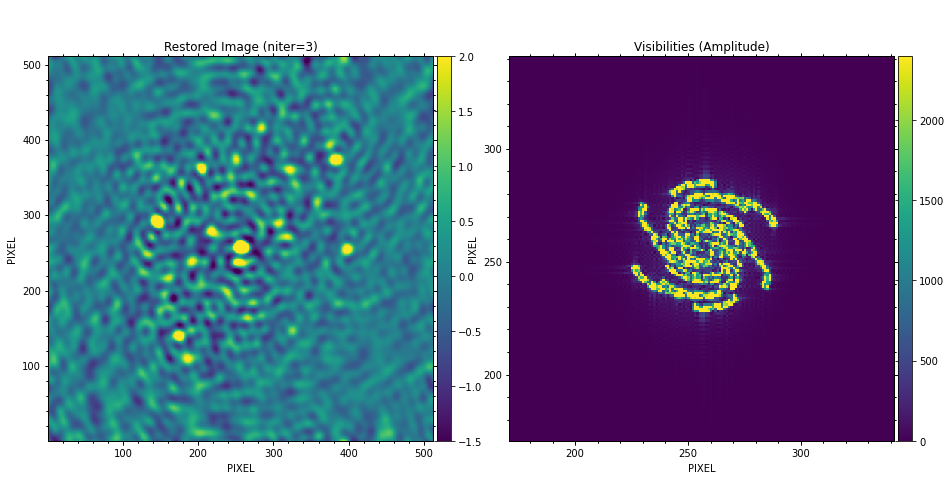

In [17]:
plotDeconvRestored(3)

*Figure: restored image and visibilities after three iterations of CLEAN. The restored image looks similar to the dirty image and the uv tracks are clear in the visibilities.*

After 30 iterations there is reduced PSF sidelobe structure in the restored image. In the visibilities the uv tracks are still apparent, but there is a low amplitude Gaussian 'haze' from the different sources. There is a beating in the visibilities because the second brightest source is to the left of the centre creating a fringe.

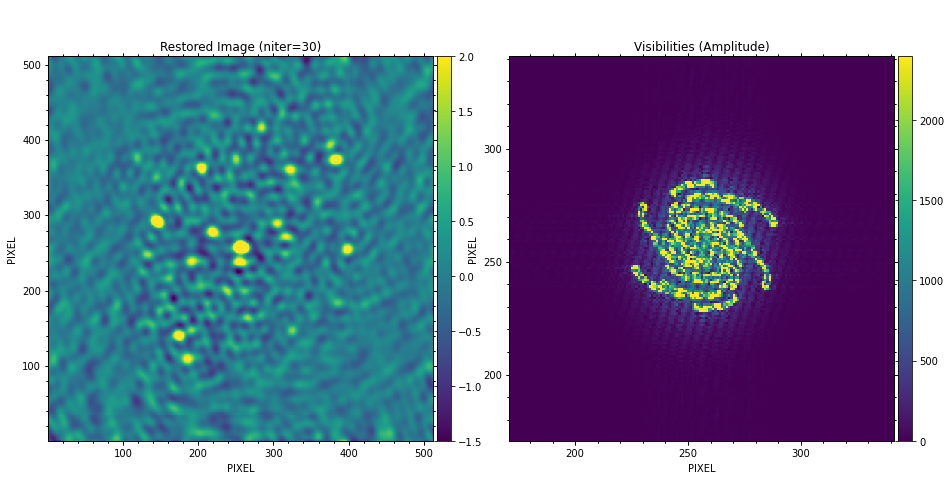

In [18]:
plotDeconvRestored(30)

*Figure: restored image and visibilities after 30 iterations of CLEAN. Many of the sidelobes in the restored image are lower and the visibilities are sampled outside of the $uv$ tracks.*

In the final deconvolution of 300 iterations the restored image has not apparent sidelobes and looks fairly good. The uv tracks in the visibilities are still some what apparent, mostly near the edge, but for the most part buried in the sampling. Because we selected a Gaussian as the ideal PSF we should expect the visibility amplitudes to decrease away from the centre, this is why the uv track are still apparent near the edge.

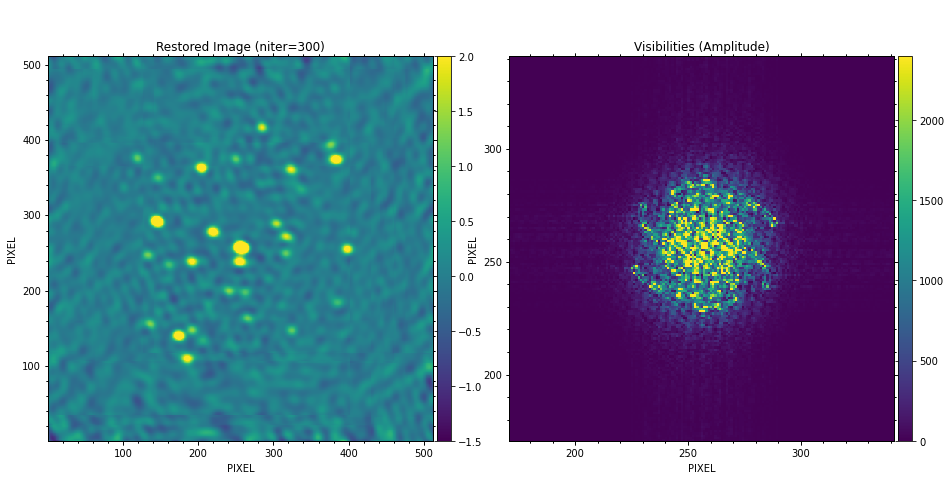

In [19]:
plotDeconvRestored(300)

*Figure: restored image and visibilities after 300 iterations of CLEAN. There are no visible sidelobes in the restored image and the visibilities are well sampled.*

An important point to make here is that `CLEAN` is filling in the unsampled visibilities by an iterative guessing approach. Because the we have not sampled all the visibility domain we do not know how good this guess is. In fact, we are only selecting one of a set of infinite possible solutions. But, the solution is based on the decent approximation that the sources in our observation are all point sources. This is a pretty good approximation a lot of the time, but not always.

### 6.3.6 Limits of CLEAN and Modern Deconvolution Developments

It is important to reiterate that iterative deconvolution is not perfect, unfortunately there is not general-purpose, perfect deconvolution method. But, iterative deconvolution is a good approximation most of the time. With the improvement in computing and the push towards better imaging there are a number of ongoing developments in deconvolution.

#### Multiple Frequencies

We have glossed over the issue of multiple frequencies. We have discussed how an increase in observing bandwidth leads to a improved *uv* coverage in [$\S$ 5.2 &#10142;](../5_Imaging/5_2_sampling_functions_and_psfs.ipynb). But, this is only true for sources which have flat spectral indicies, which never occurs. But, this is a good approximation when the bandwidth is narrow enough such that sources can be treated as flat spectrum. This can work well in many cases, but for wide bandwidth observations this approximation breaks down. A better approximation is to treat each source as having a flux and spectral index parameter (instead of just a flux parameter) which are determined during deconvolution, this process is called [<cite data-cite='2011A&A...532A..71R'>multi-frequency synthesis</cite> &#10548;](http://arxiv.org/abs/1106.2745).

#### Widefield Approximation

From the  van Cittert-Zernike theorem we kow the visibility-image domain Fourier relation only holds for the small angle approximation. We can correct for this by using more computing power to improve the approximation with w-term correction, see [$\S$ 5.5 &#10142;](../5_Imaging/5_5_widefield_effect.ipynb). Many modern imagers and deconvolution algorithms include w-term correction options by default. But, a limitation of `CLEAN` is that the PSF that is used during the minor cycle is the PSF for the array pointing at the phase centre. In fact, the PSF changes depending on direction, so sources far from the phase centre will have been convolved with a different PSF response compared to the deconvolving PSF. This leads to poor deconvolution results with a point source being spread out into different components at slightly different positions. See [<cite data-cite='1992A&A...261..353C'>Radio-interferometric imaging of very large fields - The problem of non-coplanar arrays</cite> &#10548;](http://adsabs.harvard.edu/abs/1992A&A...261..353C) for solutions using facet imaging and 3-D Fourier transforms.

#### Extended Sources

We have not discussed deconvolution of extended sources in depth. This is a coplex topic and one of the main challenges in developing modern deconvolution algorithms. Extended sources greatly open up the parameter space and are difficult to work with in a geenric way. An expansion of the point-source based deconvolution method has been [<cite data-cite='2011A&A...532A..71R'>multi-scale CLEAN</cite> &#10548;](http://arxiv.org/abs/1106.2745) which  introduces a Gaussian basis set along with the $\delta$-fuction basis set which is used to model any source with Gaussians of different size scales.

Another approach has been to take advantage of developments in compressed sensing to perform deconvolution in different basis domains, such as wavelet-based deconvoltion ([<cite data-cite='2015A&A...576A...7D'>MORESANE</cite> &#10548;](http://arxiv.org/abs/1412.5387)).

#### Model Selection

An interesting research focus has been on Bayesian model selection ([<cite data-cite='2015MNRAS.450.1308L'>BIRO</cite> &#10548;](http://arxiv.org/abs/1501.05304)) which attempts to avoid deconvolution by determining a probabilistic model based on the observed visibilities. The idea here is that deconvolution is an approximate, intermediate step which can be avoided. Further, by avoiding deconvolution a probability can be set on different models. 

#### Imaging and Deconvolution algorithms

There are many implementations of imaging and deconvolution algorithms (often combined into one package), some generic, usable ones are:

* [CASA clean &#10548;](https://casa.nrao.edu/docs/TaskRef/clean-task.html) : full-featured imager and deconvolver included in NRAO's CASA package.
* [lwimager &#10548;](https://github.com/casacore/casarest) : light-weight imager and deconvolver, stable but new features are not being added.
* [wsclean &#10548;](https://sourceforge.net/projects/wsclean/) : generic widefield imager and deconvolver.

When we talk about `clean` we mean a class of various iterative deconvolution methods, not just a single method. There are various modifications and extension of the original `clean` methods which are now used regularly in synthesis imaging. One topic we have not discussed so far is when do we decide to halt the deconvolution process and how do we know we have maximized the amount of deconvolution possible? These are difficult questions to answer,  we will discuss why this is so in the next section.

***

Next: [6.4 Residuals and Image Quality](6_4_residuals_and_iqa.ipynb)

<div class=warn><b>Future Additions:</b></div>

* example: CLEAN implementation limits: hogbom deconvolution region, clark/hogbom aliasing and regions, compare three methods
* CLEAN relation to compressed sensing/matching pursuit
* expand MFS discussion, see https://casa.nrao.edu/Release3.3.0/docs/UserMan/UserMansu232.html
* limitations: extended source example
* example: changing the gain factor